# Step 1

Dossier images existe : True
Fichier labels existe : True

--- Chargement des données ---
✅ Chargement réussi ! Total images valides : 90000
     filename  target  gender
0  000000.jpg      -1      -1
1  000001.jpg       1      -1
2  000002.jpg      -1      -1
3  000003.jpg      -1       1
4  000004.jpg       1       1

--- Distribution Croisée (Genre x Target) ---


,Target -1,Target 1
Femmes (-1),40005,13033
Hommes (1),32516,4446


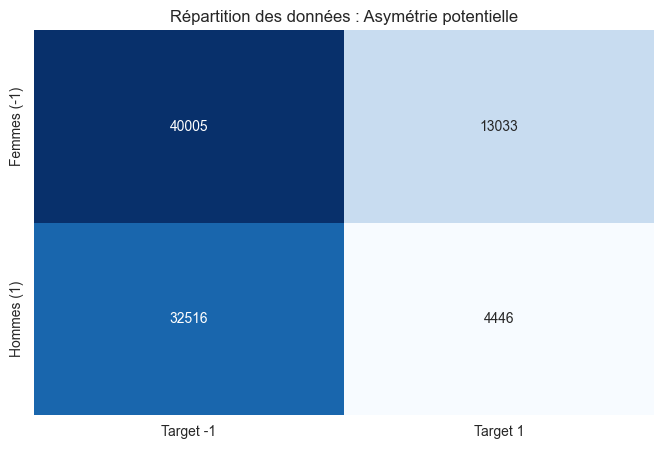


--- Visualisation des échantillons ---


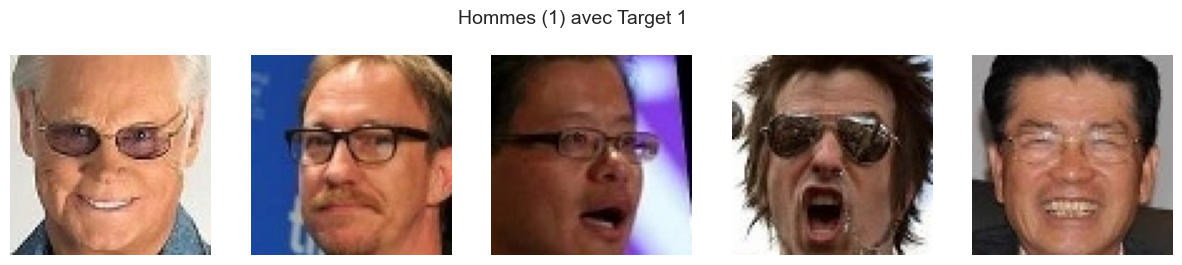

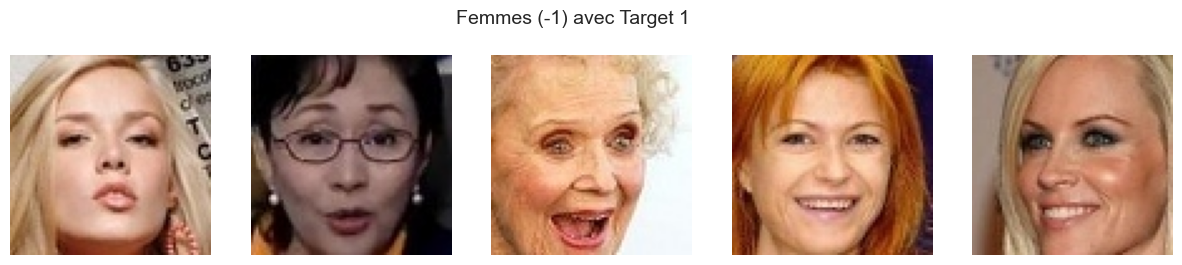


--- Split Terminé ---
Train Set : 72000 images
Val Set   : 18000 images


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


TRAIN_DIR = './train'
LABELS_PATH = './train.txt'

print(f"Dossier images existe : {os.path.exists(TRAIN_DIR)}")
print(f"Fichier labels existe : {os.path.exists(LABELS_PATH)}")


print("\n--- Chargement des données ---")
try:
    df = pd.read_csv(LABELS_PATH, sep=r"\s+", names=['filename', 'target', 'gender'], engine='python')

    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"⚠️ Attention : {nan_count} valeurs manquantes supprimées.")
        df = df.dropna()


    df['target'] = df['target'].astype(int)
    df['gender'] = df['gender'].astype(int)

    print(f"✅ Chargement réussi ! Total images valides : {len(df)}")
    print(df.head())

except Exception as e:
    print(f"❌ Erreur critique : {e}")
    raise


cross_tab = pd.crosstab(df['gender'], df['target'])
cross_tab.index = ['Femmes (-1)', 'Hommes (1)']
cross_tab.columns = ['Target -1', 'Target 1']

print("\n--- Distribution Croisée (Genre x Target) ---")
display(cross_tab)


plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Répartition des données : Asymétrie potentielle")
plt.show()


def show_examples(df, folder, target, gender, title, n=5):
    subset = df[(df['target'] == target) & (df['gender'] == gender)]
    if len(subset) == 0: return

    samples = subset.sample(min(n, len(subset)))

    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=14)
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(folder, row['filename'])
        try:
            img = Image.open(img_path)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.axis('off')
        except:
            pass
    plt.show()

print("\n--- Visualisation des échantillons ---")
show_examples(df, TRAIN_DIR, target=1, gender=1, title="Hommes (1) avec Target 1")
show_examples(df, TRAIN_DIR, target=1, gender=-1, title="Femmes (-1) avec Target 1")


df['stratify_col'] = df['target'].astype(str) + "_" + df['gender'].astype(str)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['stratify_col']
)

train_df = train_df.drop(columns=['stratify_col'])
val_df = val_df.drop(columns=['stratify_col'])

print("\n--- Split Terminé ---")
print(f"Train Set : {len(train_df)} images")
print(f"Val Set   : {len(val_df)} images")

# Step 2

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
from torchvision import transforms
import optuna


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Optimisation sur : {DEVICE}")


class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])

        try:
            image = Image.open(img_name).convert('RGB')
        except:
            image = Image.new('RGB', (80, 80))

        target_val = 1.0 if self.dataframe.iloc[idx]['target'] == 1 else 0.0
        gender_val = 1.0 if self.dataframe.iloc[idx]['gender'] == 1 else 0.0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target_val, dtype=torch.float32), torch.tensor(gender_val, dtype=torch.float32)

train_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_ds = FaceDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_ds = FaceDataset(val_df, TRAIN_DIR, transform=val_transforms)


class DynamicCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DynamicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

def calculate_esiea_metric(preds, targets, genders):
    preds_bin = (torch.sigmoid(preds) > 0.5).float()
    mask_m = (genders == 1)
    mask_f = (genders == 0)
    acc_m = (preds_bin[mask_m] == targets[mask_m]).float().mean().item() if mask_m.sum() > 0 else 0
    acc_f = (preds_bin[mask_f] == targets[mask_f]).float().mean().item() if mask_f.sum() > 0 else 0
    return ((acc_m + acc_f) / 2) - (2 * abs(acc_m - acc_f))

def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15)


    indices = np.random.choice(len(train_ds), size=int(len(train_ds)*0.3), replace=False)
    train_subset = Subset(train_ds, indices)

    val_indices = np.random.choice(len(val_ds), size=int(len(val_ds)*0.4), replace=False)
    val_subset = Subset(val_ds, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = DynamicCNN(dropout_rate=dropout).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()


    for epoch in range(2):
        model.train()
        for images, targets, _ in train_loader:
            # Lissage manuel
            targets_smoothed = targets * (1 - smoothing) + 0.5 * smoothing
            images, targets_smoothed = images.to(DEVICE), targets_smoothed.to(DEVICE).unsqueeze(1)

            optimizer.zero_grad()
            loss = criterion(model(images), targets_smoothed)
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        all_preds, all_targs, all_gends = [], [], []
        with torch.no_grad():
            for imgs, targs, gends in val_loader:
                imgs = imgs.to(DEVICE)
                outputs = model(imgs)
                all_preds.append(outputs.cpu())
                all_targs.append(targs)
                all_gends.append(gends)

        score = calculate_esiea_metric(
            torch.cat(all_preds),
            torch.cat(all_targs).unsqueeze(1),
            torch.cat(all_gends).unsqueeze(1)
        )

        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

print("Démarrage du Random Search (Version CPU Safe & Rapide)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("-" * 40)
print(f"Meilleur Score ESIEA : {study.best_value:.4f}")
print("Meilleurs Paramètres : ", study.best_params)

[I 2025-11-20 14:43:39,058] A new study created in memory with name: no-name-5984ac79-7e40-4efb-bbc7-2e11bf431eab


Optimisation sur : cpu
Démarrage du Random Search (Version CPU Safe & Rapide)...


[I 2025-11-20 14:49:20,885] Trial 0 finished with value: 0.8233712017536163 and parameters: {'lr': 0.0010678322203634789, 'dropout': 0.4513587917827853, 'batch_size': 64, 'label_smoothing': 0.09987481961413386}. Best is trial 0 with value: 0.8233712017536163.
[I 2025-11-20 14:54:01,669] Trial 1 finished with value: 0.8218580186367035 and parameters: {'lr': 0.00015205986933252458, 'dropout': 0.42233098285144016, 'batch_size': 64, 'label_smoothing': 0.025029138625318158}. Best is trial 0 with value: 0.8233712017536163.
[I 2025-11-20 14:58:54,310] Trial 2 finished with value: 0.8303735554218292 and parameters: {'lr': 0.0005241597320995532, 'dropout': 0.37887530194203073, 'batch_size': 64, 'label_smoothing': 0.08241461019892267}. Best is trial 2 with value: 0.8303735554218292.
[I 2025-11-20 15:03:33,493] Trial 3 finished with value: 0.8402578234672546 and parameters: {'lr': 0.0001843693916067429, 'dropout': 0.5882940007335425, 'batch_size': 64, 'label_smoothing': 0.046287086000741856}. Bes

----------------------------------------
Meilleur Score ESIEA : 0.8648
Meilleurs Paramètres :  {'lr': 0.0008043319031691085, 'dropout': 0.3510417764943409, 'batch_size': 32, 'label_smoothing': 0.10753515327334742}


# Step 3: TRAIN

Entraînement final (Ensembling 3 modèles) sur cpu
Répartition des 4 groupes : [32004 10426 26013  3557]
✅ Sampler activé : Les batchs contiendront autant de femmes que d'hommes !
⚖️ Poids de correction (Focal Loss) : 1.00

ENTRAÎNEMENT MODÈLE 1/3


Epoch 1/10: 100%|██████████| 2250/2250 [15:51<00:00,  2.36it/s, loss=0.0918]


Epoch 1 | Loss: 0.0918 | acc: 0.91 | ESIEA: 0.8612 | H: 91.6% | F: 89.4%
>>> Modèle 0 sauvegardé !


Epoch 2/10: 100%|██████████| 2250/2250 [08:01<00:00,  4.68it/s, loss=0.0679]


Epoch 2 | Loss: 0.0679 | acc: 0.9 | ESIEA: 0.8322 | H: 92.2% | F: 88.6%


Epoch 3/10: 100%|██████████| 2250/2250 [09:07<00:00,  4.11it/s, loss=0.0618]


Epoch 3 | Loss: 0.0618 | acc: 0.92 | ESIEA: 0.8664 | H: 93.4% | F: 90.7%
>>> Modèle 0 sauvegardé !


Epoch 4/10: 100%|██████████| 2250/2250 [07:24<00:00,  5.06it/s, loss=0.0565]


Epoch 4 | Loss: 0.0565 | acc: 0.93 | ESIEA: 0.8600 | H: 95.0% | F: 91.4%


Epoch 5/10: 100%|██████████| 2250/2250 [08:19<00:00,  4.51it/s, loss=0.0546]


Epoch 5 | Loss: 0.0546 | acc: 0.91 | ESIEA: 0.8260 | H: 93.0% | F: 88.9%


Epoch 6/10: 100%|██████████| 2250/2250 [07:48<00:00,  4.80it/s, loss=0.052] 


Epoch 6 | Loss: 0.0520 | acc: 0.92 | ESIEA: 0.8150 | H: 94.2% | F: 89.1%


Epoch 7/10: 100%|██████████| 2250/2250 [07:51<00:00,  4.77it/s, loss=0.0499]


Epoch 7 | Loss: 0.0499 | acc: 0.93 | ESIEA: 0.7938 | H: 96.1% | F: 89.4%


Epoch 8/10: 100%|██████████| 2250/2250 [08:51<00:00,  4.24it/s, loss=0.0442]


Epoch 8 | Loss: 0.0442 | acc: 0.93 | ESIEA: 0.8243 | H: 96.3% | F: 90.7%


Epoch 9/10: 100%|██████████| 2250/2250 [07:57<00:00,  4.71it/s, loss=0.0412]


Epoch 9 | Loss: 0.0412 | acc: 0.93 | ESIEA: 0.8103 | H: 96.4% | F: 90.2%


Epoch 10/10: 100%|██████████| 2250/2250 [07:39<00:00,  4.89it/s, loss=0.0401]


Epoch 10 | Loss: 0.0401 | acc: 0.94 | ESIEA: 0.8270 | H: 96.6% | F: 91.0%

ENTRAÎNEMENT MODÈLE 2/3


Epoch 1/10: 100%|██████████| 2250/2250 [07:40<00:00,  4.89it/s, loss=0.0972]


Epoch 1 | Loss: 0.0972 | acc: 0.93 | ESIEA: 0.8360 | H: 95.1% | F: 90.5%
>>> Modèle 1 sauvegardé !


Epoch 2/10: 100%|██████████| 2250/2250 [08:32<00:00,  4.39it/s, loss=0.0678]


Epoch 2 | Loss: 0.0678 | acc: 0.92 | ESIEA: 0.8817 | H: 93.0% | F: 91.1%
>>> Modèle 1 sauvegardé !


Epoch 3/10: 100%|██████████| 2250/2250 [07:57<00:00,  4.72it/s, loss=0.0625]


Epoch 3 | Loss: 0.0625 | acc: 0.91 | ESIEA: 0.8639 | H: 91.9% | F: 89.7%


Epoch 4/10: 100%|██████████| 2250/2250 [07:35<00:00,  4.94it/s, loss=0.0581]


Epoch 4 | Loss: 0.0581 | acc: 0.92 | ESIEA: 0.8191 | H: 94.4% | F: 89.4%


Epoch 5/10: 100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s, loss=0.0549]


Epoch 5 | Loss: 0.0549 | acc: 0.92 | ESIEA: 0.8223 | H: 94.4% | F: 89.6%


Epoch 6/10: 100%|██████████| 2250/2250 [08:50<00:00,  4.24it/s, loss=0.0523]


Epoch 6 | Loss: 0.0523 | acc: 0.93 | ESIEA: 0.8501 | H: 94.8% | F: 90.9%


Epoch 7/10: 100%|██████████| 2250/2250 [08:22<00:00,  4.48it/s, loss=0.0454]


Epoch 7 | Loss: 0.0454 | acc: 0.94 | ESIEA: 0.8340 | H: 96.6% | F: 91.3%


Epoch 8/10: 100%|██████████| 2250/2250 [07:56<00:00,  4.73it/s, loss=0.0436]


Epoch 8 | Loss: 0.0436 | acc: 0.93 | ESIEA: 0.8287 | H: 96.1% | F: 90.8%


Epoch 9/10: 100%|██████████| 2250/2250 [07:36<00:00,  4.93it/s, loss=0.0424]


Epoch 9 | Loss: 0.0424 | acc: 0.93 | ESIEA: 0.8374 | H: 95.5% | F: 90.8%


Epoch 10/10: 100%|██████████| 2250/2250 [07:33<00:00,  4.96it/s, loss=0.0417]


Epoch 10 | Loss: 0.0417 | acc: 0.94 | ESIEA: 0.8380 | H: 96.5% | F: 91.4%

ENTRAÎNEMENT MODÈLE 3/3


Epoch 1/10: 100%|██████████| 2250/2250 [08:43<00:00,  4.30it/s, loss=0.0978]


Epoch 1 | Loss: 0.0978 | acc: 0.9 | ESIEA: 0.8859 | H: 89.9% | F: 89.3%
>>> Modèle 2 sauvegardé !


Epoch 2/10: 100%|██████████| 2250/2250 [10:28<00:00,  3.58it/s, loss=0.0693]


Epoch 2 | Loss: 0.0693 | acc: 0.87 | ESIEA: 0.8065 | H: 89.1% | F: 85.7%


Epoch 3/10: 100%|██████████| 2250/2250 [08:21<00:00,  4.49it/s, loss=0.064] 


Epoch 3 | Loss: 0.0640 | acc: 0.89 | ESIEA: 0.8003 | H: 91.3% | F: 86.8%


Epoch 4/10: 100%|██████████| 2250/2250 [09:17<00:00,  4.04it/s, loss=0.0601]


Epoch 4 | Loss: 0.0601 | acc: 0.93 | ESIEA: 0.8681 | H: 95.0% | F: 91.8%


Epoch 5/10: 100%|██████████| 2250/2250 [09:25<00:00,  3.98it/s, loss=0.0565]


Epoch 5 | Loss: 0.0565 | acc: 0.93 | ESIEA: 0.8249 | H: 95.7% | F: 90.4%


Epoch 6/10: 100%|██████████| 2250/2250 [09:30<00:00,  3.95it/s, loss=0.0501]


Epoch 6 | Loss: 0.0501 | acc: 0.93 | ESIEA: 0.8287 | H: 95.7% | F: 90.6%


Epoch 7/10: 100%|██████████| 2250/2250 [07:50<00:00,  4.79it/s, loss=0.0481]


Epoch 7 | Loss: 0.0481 | acc: 0.93 | ESIEA: 0.8289 | H: 95.6% | F: 90.5%


Epoch 8/10: 100%|██████████| 2250/2250 [13:43<00:00,  2.73it/s, loss=0.0475]  


Epoch 8 | Loss: 0.0475 | acc: 0.93 | ESIEA: 0.8348 | H: 96.0% | F: 91.0%


Epoch 9/10: 100%|██████████| 2250/2250 [07:25<00:00,  5.05it/s, loss=0.0463]


Epoch 9 | Loss: 0.0463 | acc: 0.94 | ESIEA: 0.8312 | H: 96.3% | F: 91.0%


Epoch 10/10: 100%|██████████| 2250/2250 [08:12<00:00,  4.57it/s, loss=0.0463]


Epoch 10 | Loss: 0.0463 | acc: 0.93 | ESIEA: 0.8173 | H: 96.0% | F: 90.3%


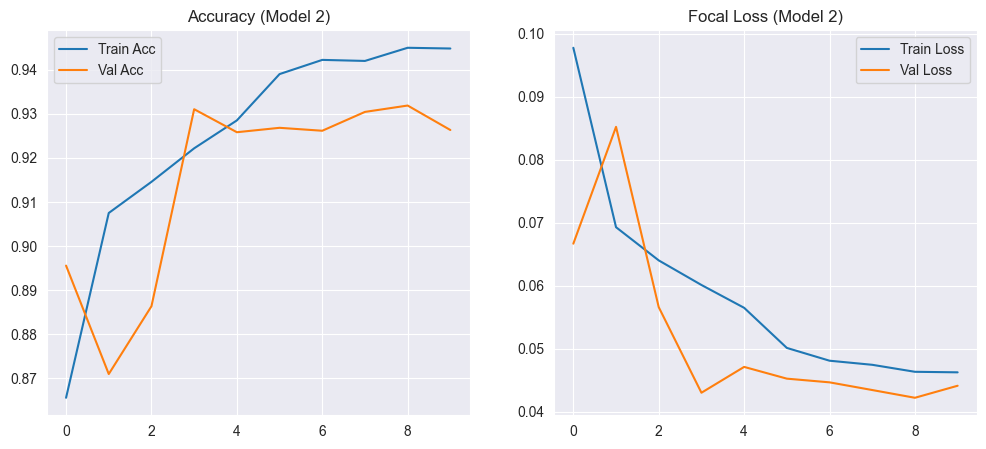

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
import numpy as np

BEST_PARAMS = {
    "lr": 0.0008043319031691085,
    "dropout": 0.3510417764943409,
    "label_smoothing": 0.10753515327334742,
    "batch_size": 32
}

EPOCHS = 10
NUM_MODELS_ENSEMBLE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NOM_FICHIER_RENDU = "predictions_Binome1_Binome2.txt"

print(f"Entraînement final (Ensembling {NUM_MODELS_ENSEMBLE} modèles) sur {DEVICE}")

class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        try: image = Image.open(img_name).convert('RGB')
        except: image = Image.new('RGB', (80, 80))
        target = 1.0 if self.dataframe.iloc[idx]['target'] == 1 else 0.0
        gender = 1.0 if self.dataframe.iloc[idx]['gender'] == 1 else 0.0
        if self.transform: image = self.transform(image)
        return image, torch.tensor(target).float(), torch.tensor(gender).float()


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

train_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_ds = FaceDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_ds = FaceDataset(val_df, TRAIN_DIR, transform=val_transforms)

y_train_indices = train_df.index.tolist()
targets = train_df['target'].values
genders = train_df['gender'].values

groups = []
for t, g in zip(targets, genders):
    if g == -1 and t == -1: groups.append(0) # Femme Négative
    elif g == -1 and t == 1: groups.append(1) # Femme Positive
    elif g == 1 and t == -1: groups.append(2) # Homme Négatif
    elif g == 1 and t == 1: groups.append(3) # Homme Positif

groups = np.array(groups)

class_counts = np.bincount(groups)
print(f"Répartition des 4 groupes : {class_counts}")

class_weights = 1. / class_counts
sample_weights = class_weights[groups]

sampler_weights = torch.from_numpy(sample_weights).double()

# Batchs équilibrés !
sampler = WeightedRandomSampler(sampler_weights, len(sampler_weights))

train_loader = DataLoader(train_ds, batch_size=BEST_PARAMS['batch_size'], shuffle=False, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BEST_PARAMS['batch_size'], shuffle=False, num_workers=0)

print("✅ Sampler activé : Les batchs contiendront autant de femmes que d'hommes !")

class DynamicCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DynamicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(512, 1)
        )
    def forward(self, x): return self.classifier(self.flatten(self.features(x)))

def calculate_esiea_metric(preds, targets, genders):
    preds_bin = (torch.sigmoid(preds) > 0.5).float()
    mask_m, mask_f = (genders == 1), (genders == 0)
    acc_m = (preds_bin[mask_m] == targets[mask_m]).float().mean().item() if mask_m.sum() > 0 else 0
    acc_f = (preds_bin[mask_f] == targets[mask_f]).float().mean().item() if mask_f.sum() > 0 else 0
    return ((acc_m + acc_f) / 2) - (2 * abs(acc_m - acc_f)), acc_m, acc_f



num_neg = len(train_df[train_df['target'] == -1])
num_pos = len(train_df[train_df['target'] == 1])
pos_weight_val = 1.0
pos_weight_tensor = torch.tensor([pos_weight_val]).to(DEVICE)
print(f"⚖️ Poids de correction (Focal Loss) : {pos_weight_val:.2f}")


for model_idx in range(NUM_MODELS_ENSEMBLE):
    print(f"\n{'='*40}")
    print(f"ENTRAÎNEMENT MODÈLE {model_idx + 1}/{NUM_MODELS_ENSEMBLE}")
    print(f"{'='*40}")

    model = DynamicCNN(dropout_rate=BEST_PARAMS['dropout']).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    criterion = FocalLoss(alpha=1, gamma=2, pos_weight=pos_weight_tensor)

    best_score = -float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for images, targets, _ in pbar:
            smooth = BEST_PARAMS['label_smoothing']
            targets_smooth = targets * (1 - smooth) + 0.5 * smooth

            images = images.to(DEVICE)
            targets_smooth = targets_smooth.to(DEVICE).unsqueeze(1)
            targets = targets.to(DEVICE).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets_smooth)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        all_preds, all_targs, all_gends = [], [], []

        with torch.no_grad():
            for imgs, targs, gends in val_loader:
                imgs = imgs.to(DEVICE)
                targs_device = targs.to(DEVICE).unsqueeze(1)

                outputs = model(imgs)
                # Validation loss (sur targets brutes)
                loss_val = criterion(outputs, targs_device)
                val_running_loss += loss_val.item()

                all_preds.append(outputs.cpu())
                all_targs.append(targs)
                all_gends.append(gends)

        # Metrics Val
        epoch_val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(epoch_val_loss)

        all_preds_cat = torch.cat(all_preds)
        all_targs_cat = torch.cat(all_targs).unsqueeze(1)
        score, acc_h, acc_f = calculate_esiea_metric(all_preds_cat, all_targs_cat, torch.cat(all_gends).unsqueeze(1))

        val_acc_global = ((torch.sigmoid(all_preds_cat) > 0.5).float() == all_targs_cat).float().mean().item()
        history['val_acc'].append(val_acc_global)

        print(f"Epoch {epoch+1} | Loss: {epoch_train_loss:.4f} | acc: {(acc_f+acc_h)/2:.2} | ESIEA: {score:.4f} | H: {acc_h:.1%} | F: {acc_f:.1%}")

        scheduler.step(score)

        if score > best_score:
            best_score = score
            torch.save(model.state_dict(), f"model_ensemble_{model_idx}.pth")
            print(f">>> Modèle {model_idx} sauvegardé !")

    # Affichage de la courbe du dernier modèle pour éviter de surcharger
    if model_idx == NUM_MODELS_ENSEMBLE - 1:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title(f'Accuracy (Model {model_idx})')
        plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f'Focal Loss (Model {model_idx})')
        plt.legend(); plt.grid(True)
        plt.show()

# Predictions

In [8]:
print("\n--- Chargement de l'Ensemble de Modèles ---")

# Chargement des 3 modèles
models = []
for i in range(NUM_MODELS_ENSEMBLE):
    m = DynamicCNN(dropout_rate=BEST_PARAMS['dropout']).to(DEVICE)

    filename = f"model_ensemble_{i}.pth"
    if os.path.exists(filename):
        m.load_state_dict(torch.load(filename, map_location=DEVICE))
        m.eval()
        models.append(m)
        print(f"✅ Modèle chargé : {filename}")
    else:
        print(f"⚠️ Attention : {filename} introuvable (Ignoré)")

print(f"\n--- Génération du fichier de rendu (Fusion de {len(models)} modèles) ---")

TEST_DIR = './test'
test_files = []

possible_paths = ['./test.txt']
list_found = False

if os.path.exists('test.txt'):
    with open('test.txt', 'r') as f:
        test_files = [line.strip().split()[0] for line in f.readlines() if line.strip()]
    print(f"📋 Liste chargée depuis : 'test.txt'")
    list_found = True

predictions = []
print(f"Traitement de {len(test_files)} images de test...")

# Utilisation du TTA (Test Time Augmentation)
with torch.no_grad():
    for img_name in tqdm(test_files):
        path = os.path.join(TEST_DIR, img_name)
        try:
            img = Image.open(path).convert('RGB')

            img_tensor = val_transforms(img).unsqueeze(0).to(DEVICE)

            img_flip = torch.flip(img_tensor, [3])

            total_prob = 0.0

            for model in models:
                p_normal = torch.sigmoid(model(img_tensor)).item()

                p_flip = torch.sigmoid(model(img_flip)).item()

                total_prob += (p_normal + p_flip) / 2

            avg_prob = total_prob / len(models)

            pred_label = 1 if avg_prob > 0.5 else -1
            predictions.append(f"{img_name} {pred_label}")

        except Exception as e:
            print(f"Erreur sur {img_name}: {e}")
            predictions.append(f"{img_name} -1")

with open(NOM_FICHIER_RENDU, 'w') as f:
    for line in predictions:
        f.write(line + "\n")

print("-" * 30)
print(f"✅ Fichier généré : {NOM_FICHIER_RENDU}")
print(f"Ce fichier contient {len(predictions)} lignes.")


--- Chargement de l'Ensemble de Modèles ---
✅ Modèle chargé : model_ensemble_0.pth
✅ Modèle chargé : model_ensemble_1.pth
✅ Modèle chargé : model_ensemble_2.pth

--- Génération du fichier de rendu (Fusion de 3 modèles) ---
📋 Liste chargée depuis : 'test.txt'
Traitement de 9999 images de test...


100%|██████████| 9999/9999 [03:06<00:00, 53.71it/s]


------------------------------
✅ Fichier généré : predictions_Binome1_Binome2.txt
Ce fichier contient 9999 lignes.



--- Visualisation des échantillons ---


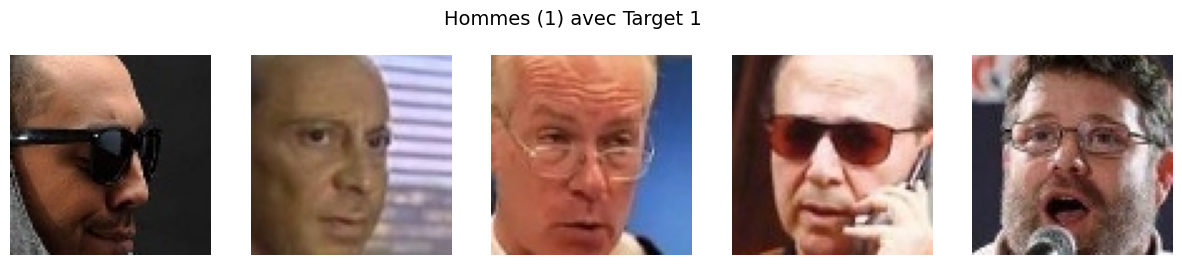

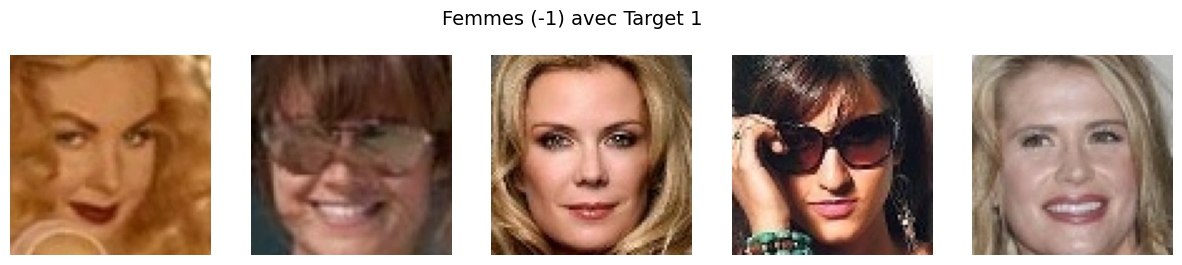

In [12]:
print("\n--- Visualisation des échantillons ---")
show_examples(df, TRAIN_DIR, target=1, gender=1, title="Hommes (1) avec Target 1")
show_examples(df, TRAIN_DIR, target=1, gender=-1, title="Femmes (-1) avec Target 1")

Génération des cartes de saillance...


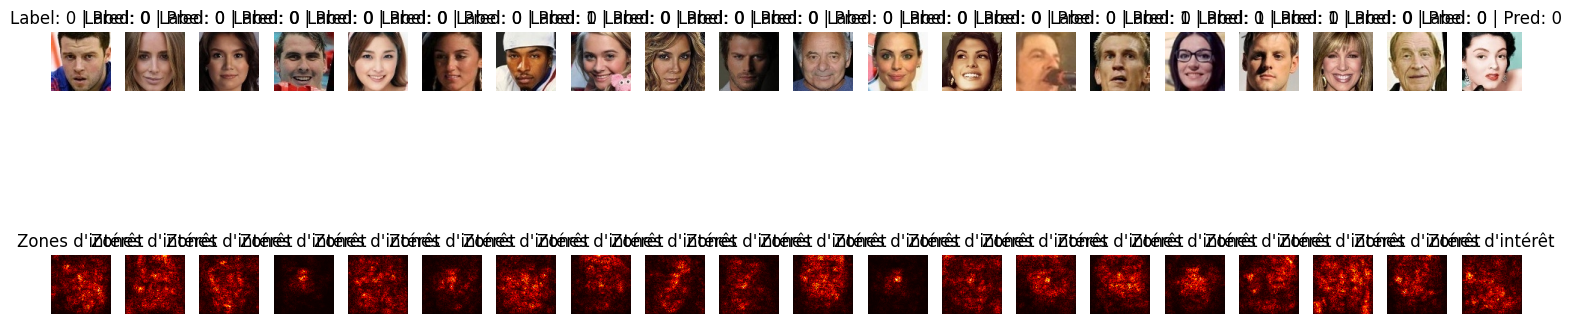

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Fonction pour générer la Saliency Map
def get_saliency_map(model, image_tensor, label_target):
    """
    Calcule les gradients de l'image par rapport au label prédit.
    """
    # On active le calcul du gradient sur l'image d'entrée (normalement désactivé)
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # On veut expliquer la classe prédite (ou la classe cible 1)
    # Ici, on maximise le score de la sortie brute
    output.backward()

    # On récupère les gradients (l'importance des pixels)
    saliency = image_tensor.grad.data.abs()

    # On prend le max sur les 3 canaux de couleur (R, G, B) pour avoir une map 2D
    saliency, _ = torch.max(saliency, dim=1)

    return saliency

# 2. Visualisation sur quelques images
def show_saliency_maps(model, loader, device, n_samples=5):
    model.eval()

    # On récupère un batch
    images, targets, genders = next(iter(loader))
    images = images.to(device)

    fig, ax = plt.subplots(2, n_samples, figsize=(15, 6))

    count = 0
    for i in range(len(images)):
        if count >= n_samples: break

        img_tensor = images[i].unsqueeze(0) # Ajoute dimension batch [1, 3, 80, 80]

        # On ne traite que les images prédites comme "1" (pour voir ce qui déclenche le 1)
        logit = model(img_tensor)
        pred = 1 if torch.sigmoid(logit).item() > 0.5 else 0

        # Affiche l'image originale (Dénormalisation pour l'affichage)
        img_display = images[i].cpu().numpy().transpose(1, 2, 0)
        img_display = img_display * 0.5 + 0.5 # De-normalize

        # Calcul Saliency
        # Note : on doit "reset" le gradient du modèle pour éviter les erreurs
        model.zero_grad()
        saliency = get_saliency_map(model, img_tensor, pred)

        # Affichage Image
        ax[0, count].imshow(np.clip(img_display, 0, 1))
        ax[0, count].set_title(f"Label: {int(targets[i].item())} | Pred: {pred}")
        ax[0, count].axis('off')

        # Affichage Heatmap
        saliency_map = saliency.cpu().numpy()[0]
        ax[1, count].imshow(saliency_map, cmap='hot')
        ax[1, count].set_title("Zones d'intérêt")
        ax[1, count].axis('off')

        count += 1

    plt.tight_layout()
    plt.show()

# --- Exécution ---
# Assurez-vous que 'model' et 'val_loader' sont chargés (Step 3)
print("Génération des cartes de saillance...")
show_saliency_maps(model, val_loader, DEVICE, n_samples=20)

Comparaison des zones d'intérêt (Target 1 vs Target -1)...


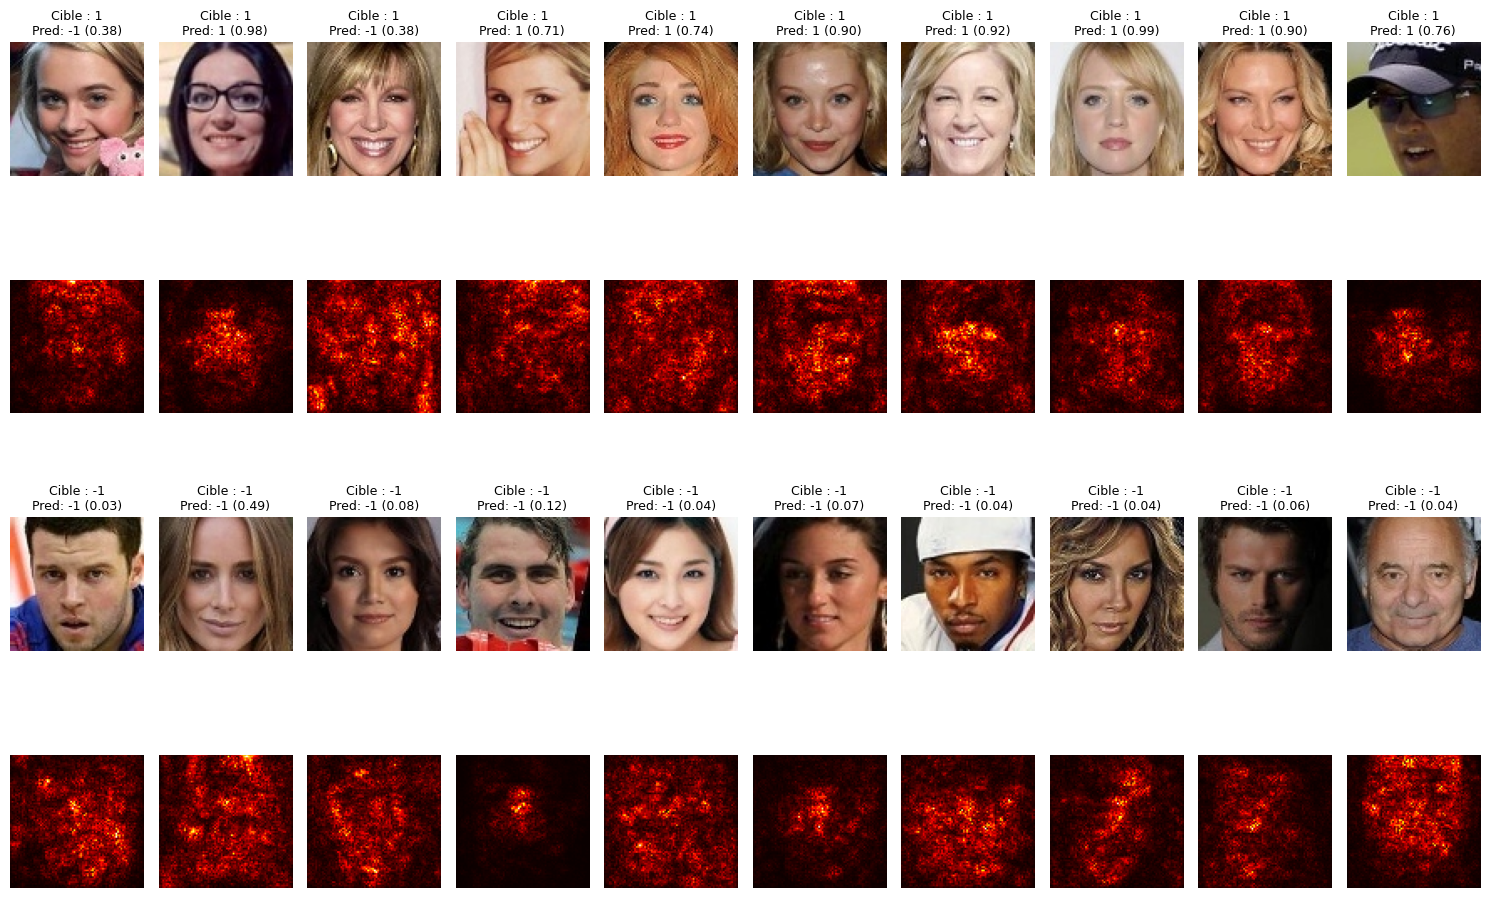

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Fonction de calcul du gradient (Saliency)
def get_saliency_map(model, image_tensor, predicted_class):
    image_tensor.requires_grad_()
    output = model(image_tensor)

    # On veut savoir quels pixels poussent vers la décision prise
    # Si le modèle prédit 1, on backprop pour maximiser le neuron 1
    # (Ici output est un logit unique, donc on backprop directement)
    output.backward()

    saliency = image_tensor.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1) # Aplatir les canaux RGB
    return saliency

def visualize_comparison(model, loader, device):
    model.eval()

    # Listes pour stocker nos échantillons
    samples_pos = [] # Pour Target 1
    samples_neg = [] # Pour Target -1 (Note: c'est 0 dans le dataset PyTorch)

    # On parcourt le loader jusqu'à avoir 5 de chaque
    for images, targets, _ in loader:
        if len(samples_pos) >= 10 and len(samples_neg) >= 10:
            break

        for i in range(len(images)):
            target_val = int(targets[i].item())

            if target_val == 1 and len(samples_pos) < 10:
                samples_pos.append(images[i])
            elif target_val == 0 and len(samples_neg) < 10:
                samples_neg.append(images[i])

    # Fonction d'affichage d'une ligne
    def plot_row(samples, title_prefix, row_idx_start):
        for i, img_tensor in enumerate(samples):
            img_input = img_tensor.unsqueeze(0).to(device)

            # Prédiction
            logit = model(img_input)
            prob = torch.sigmoid(logit).item()
            pred_label = 1 if prob > 0.5 else -1 # Affichage en label original (-1/1)

            # Saliency
            model.zero_grad()
            saliency = get_saliency_map(model, img_input, pred_label)

            # Préparation affichage
            img_display = img_tensor.cpu().numpy().transpose(1, 2, 0)
            img_display = img_display * 0.5 + 0.5 # Dénormalisation
            saliency_map = saliency.cpu().numpy()[0]

            # Plot Image Originale
            ax[row_idx_start, i].imshow(np.clip(img_display, 0, 1))
            ax[row_idx_start, i].set_title(f"{title_prefix}\nPred: {pred_label} ({prob:.2f})", fontsize=9)
            ax[row_idx_start, i].axis('off')

            # Plot Heatmap
            ax[row_idx_start + 1, i].imshow(saliency_map, cmap='hot')
            ax[row_idx_start + 1, i].axis('off')

    # Création de la figure (4 lignes : Images Pos, Heatmap Pos, Images Neg, Heatmap Neg)
    fig, ax = plt.subplots(4, 10, figsize=(15, 10))

    # Lignes 1 et 2 : Target 1
    plot_row(samples_pos, "Cible : 1", 0)
    ax[0, 0].set_ylabel("Original (1)", size='large')
    ax[1, 0].set_ylabel("Saliency (1)", size='large')

    # Lignes 3 et 4 : Target -1
    plot_row(samples_neg, "Cible : -1", 2)
    ax[2, 0].set_ylabel("Original (-1)", size='large')
    ax[3, 0].set_ylabel("Saliency (-1)", size='large')

    plt.tight_layout()
    plt.show()

# --- Lancement ---
# Assurez-vous que 'model' et 'val_loader' sont définis (Step 3)
print("Comparaison des zones d'intérêt (Target 1 vs Target -1)...")
visualize_comparison(model, val_loader, DEVICE)